In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
df = pd.read_csv('porter_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 14 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     175777 non-null  float64
 1   created_at                                    175777 non-null  object 
 2   actual_delivery_time                          175777 non-null  object 
 3   store_primary_category                        175777 non-null  int64  
 4   order_protocol                                175777 non-null  float64
 5   total_items                                   175777 non-null  int64  
 6   subtotal                                      175777 non-null  int64  
 7   num_distinct_items                            175777 non-null  int64  
 8   min_item_price                                175777 non-null  int64  
 9   max_item_price                                17

In [4]:
df.head()

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:11:17,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:33:25,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,690.0
2,2.0,2015-02-16 00:11:35,2015-02-16 01:06:35,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,289.0
3,1.0,2015-02-12 03:36:46,2015-02-12 04:35:46,38,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,795.0
4,1.0,2015-01-27 02:12:36,2015-01-27 02:58:36,38,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,205.0


In [5]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

df['delivery_duration'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds()

In [6]:
df = df.drop(columns=['market_id','created_at','actual_delivery_time','store_primary_category','order_protocol'])

In [7]:
df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,delivery_duration
0,4,3441,4,557,1239,33.0,14.0,21.0,861.0,2820.0
1,1,1900,1,1400,1400,1.0,2.0,2.0,690.0,2640.0
2,4,4771,3,820,1604,8.0,6.0,18.0,289.0,3300.0
3,1,1525,1,1525,1525,5.0,6.0,8.0,795.0,3540.0
4,2,3620,2,1425,2195,5.0,5.0,7.0,205.0,2760.0


In [8]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42))
])

In [9]:
X = df.drop(columns=['delivery_duration'])
y = df['delivery_duration']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [11]:
param_grid = {
    'model__n_estimators':[50,200],
    'model__max_depth':[None,5]
}

In [12]:
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_absolute_error'
)

In [13]:
grid.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 5],
                         'model__n_estimators': [50, 200]},
             scoring='neg_mean_absolute_error')

In [14]:
print(f"Best params: {grid.best_params_} ")
print("Best Score (neg MAE):", grid.best_score_)

Best params: {'model__max_depth': None, 'model__n_estimators': 200} 
Best Score (neg MAE): -153.7132019217895


In [15]:
y_pred = grid.predict(X_test)

In [16]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")

MAE: 151.38
MSE: 39852.38
RMSE: 199.63
R2 Score: 0.87


In [17]:
#example 
sample = pd.DataFrame([[3, 3200, 3, 800, 1200, 10, 5, 8, 750]], columns=X.columns)

example_predict = grid.best_estimator_.predict(sample)[0]

print(f"Estimated delivery time: {example_predict:.1f} seconds ({example_predict/60:.1f} minutes)")

Estimated delivery time: 3107.1 seconds (51.8 minutes)


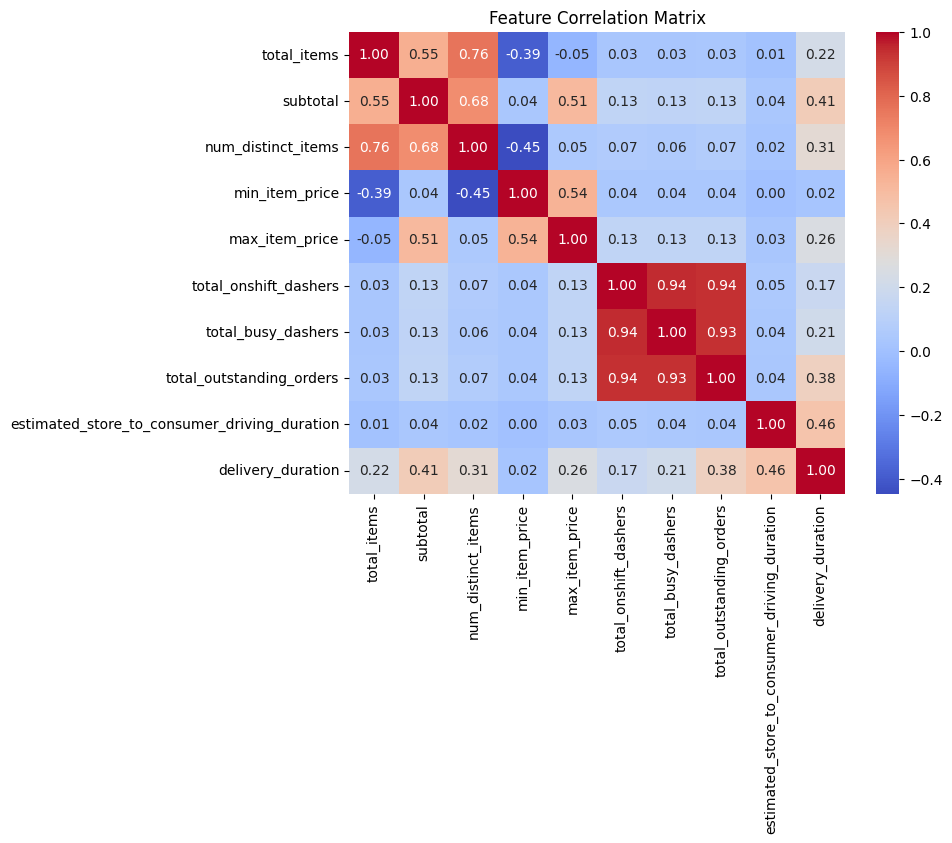

In [18]:

corr = df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [19]:
df = df.drop(columns=['total_busy_dashers','total_onshift_dashers'])
df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_store_to_consumer_driving_duration,delivery_duration
0,4,3441,4,557,1239,21.0,861.0,2820.0
1,1,1900,1,1400,1400,2.0,690.0,2640.0
2,4,4771,3,820,1604,18.0,289.0,3300.0
3,1,1525,1,1525,1525,8.0,795.0,3540.0
4,2,3620,2,1425,2195,7.0,205.0,2760.0


In [20]:
X = df.drop('delivery_duration',axis=1)
y = df['delivery_duration']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [22]:
grid.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 5],
                         'model__n_estimators': [50, 200]},
             scoring='neg_mean_absolute_error')

In [23]:
y_pred = grid.predict(X_test)

In [24]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")

MAE: 290.55
MSE: 146158.60
RMSE: 382.31
R2 Score: 0.54


In [25]:
#example
sample = pd.DataFrame([[3, 3200, 3, 800, 1200, 10, 750]], columns=X.columns)

example_predict = grid.best_estimator_.predict(sample)[0]

print(f"Estimated delivery time: {example_predict:.1f} seconds ({example_predict/60:.1f} minutes)")

Estimated delivery time: 3235.8 seconds (53.9 minutes)


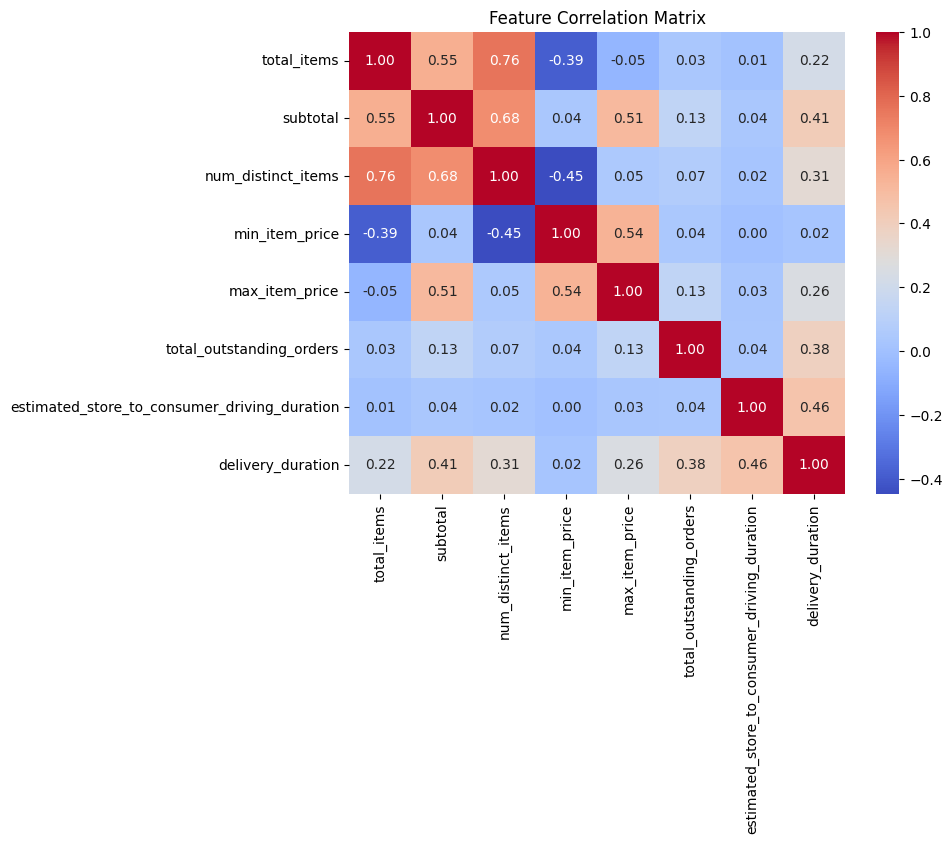

In [26]:
corr = df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

When I removed two highly correlated features (total_busy_dashers and total_onshift_dashers), the model performance dropped:

R2 score decreased from 0.87 to 0.54, and MAE increased from 151 to 291 seconds.
This means those features were important for predicting delivery time.
So, keeping all related features in the model gives better and more accurate results.